# Data Representation and Pipelines

An important step in developing machine learning models is determining how to represent network traffic as input to those models.  One possible way to represent packets is using a standard, algined traffic fingerprint called an [nPrint](https://nprint.github.io/nprint/). 

In this notebook/exercise, we will:
* Explore how to represent network traffic with a standard representation ([nPrint](https://nprint.github.io/nprint/))
* Show how nPrint can be coupled with an AutoML pipeline to automatically evaluate a range of machine learning models.

### Requirements

nPrint must be installed into $PATH for external commands to work. Note: You may not be able to do this part in Google collab; it may only work if you have a local (Linux) machine on which you are running the notebook.  If that is the case, the second cell where you execute the commands on pcaps may not run, but we have provided the "npt" nprint output files as well, so you can run the rest of the notebook.


#### Learning Objectives

By the end of this activity you will:

1. Understand how to take a packet trace and represent it in a standard, generic form.
2. Run nprint on a few classes of machine learning algorithms.
3. Try the pipeline on some of your own (labeled) packet traces to understand how to build an end-to-end machine learning pipeline for a cybersecurity problem.

#### Tasks

1. Install nprint and run it on a packet trace---either the one provided, one that is available from public repositories (e.g., CICIDS). Optionally, try it on your own traffic.
2. Run the notebook below to understand nprint and the basic machine learning pipeline.
3. Try nprint on a new (security) classification problem, using one of the provided datasets.

---

## Example: Encrypted vs. Unencrypted Traffic 

There are 2 `pcap` files that we will use in this example:

1. `port443.pcap` - a small trace of packets sent and received over https  
2. `port80.pcap` - a small trace of packets sent and received over http

We will (1) generate nprints for each of these packet traces; (2) train and evaluate a classifier using these samples.

### Step 1: Generate nPrints

In [4]:
nprint = '/usr/local/bin/nprint'
data = '../data'

cmd_80 = '{} -P {}/port80.pcap -t -W {}/port80.npt'.format(nprint, data, data)
cmd_443 = '{} -P {}/port443.pcap -t -W {}/port443.npt'.format(nprint, data, data)
!{cmd_80}
!{cmd_443}

/bin/bash: line 1: /usr/local/bin/nprint: No such file or directory
/bin/bash: line 1: /usr/local/bin/nprint: No such file or directory


In [5]:
import pandas as pd
nprint_80 = pd.read_csv('{}/port80.npt'.format(data), index_col=0)
nprint_443 = pd.read_csv('{}/port443.npt'.format(data), index_col=0)

print('Port 80 nPrint:\t\t Number of Packets: {0}, Features per packet: {1}'.format(nprint_80.shape[0], nprint_80.shape[1]))
print('Port 443 nPrint:\t Number of Packets: {0}, Features per packet: {1}'.format(nprint_443.shape[0], nprint_443.shape[1]))

Port 80 nPrint:		 Number of Packets: 2421, Features per packet: 480
Port 443 nPrint:	 Number of Packets: 2500, Features per packet: 480


In [6]:
print(nprint_80.columns)
print(nprint_443.columns)

Index(['tcp_sprt_0', 'tcp_sprt_1', 'tcp_sprt_2', 'tcp_sprt_3', 'tcp_sprt_4',
       'tcp_sprt_5', 'tcp_sprt_6', 'tcp_sprt_7', 'tcp_sprt_8', 'tcp_sprt_9',
       ...
       'tcp_opt_310', 'tcp_opt_311', 'tcp_opt_312', 'tcp_opt_313',
       'tcp_opt_314', 'tcp_opt_315', 'tcp_opt_316', 'tcp_opt_317',
       'tcp_opt_318', 'tcp_opt_319'],
      dtype='object', length=480)
Index(['tcp_sprt_0', 'tcp_sprt_1', 'tcp_sprt_2', 'tcp_sprt_3', 'tcp_sprt_4',
       'tcp_sprt_5', 'tcp_sprt_6', 'tcp_sprt_7', 'tcp_sprt_8', 'tcp_sprt_9',
       ...
       'tcp_opt_310', 'tcp_opt_311', 'tcp_opt_312', 'tcp_opt_313',
       'tcp_opt_314', 'tcp_opt_315', 'tcp_opt_316', 'tcp_opt_317',
       'tcp_opt_318', 'tcp_opt_319'],
      dtype='object', length=480)


Notice how each bit (feature) is named according to the exact bit it represents in the packet, and all the possible bits of a TCP header are accounted for.

In [7]:
import numpy as np

features = []
targets = []
for _, row in nprint_80.iterrows():
    features.append(np.array(row))
    targets.append('unencrypted')

for _, row in nprint_443.iterrows():
    features.append(np.array(row))
    targets.append('encrypted')

## Training a Classifier

We're already ready to train and test a model on the traffic we gathered. Let's split the data into training and testing data, train a model, and get a stat report.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

# Split data
X_train, X_test, y_train, y_test = train_test_split(features, targets)

# Initialize Classifier
clf = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=2, random_state=0)

# Train 
clf.fit(X_train, y_train) 

# Predict
y_pred = clf.predict(X_test)

# Statistics

# First, lets get a stat report about the precision and recall:
report = classification_report(y_test, y_pred)
print(report)

# Let's also get the ROC AUC score while we're here, which requires a probability instead of just the prediction
y_pred_proba = clf.predict_proba(X_test)
# predict_proba gives us a probability estimate of each class, while roc_auc just cares about the "positive" class
y_pred_proba_pos = [sublist[1] for sublist in y_pred_proba]
roc = roc_auc_score(y_test, y_pred_proba_pos)
print('ROC AUC Score: {0}'.format(roc))

              precision    recall  f1-score   support

   encrypted       1.00      1.00      1.00       623
 unencrypted       1.00      1.00      1.00       608

    accuracy                           1.00      1231
   macro avg       1.00      1.00      1.00      1231
weighted avg       1.00      1.00      1.00      1231

ROC AUC Score: 1.0


## Understanding the Model

nPrint's alignment of each packet allows for understanding the specific features (parts of the packet) that are driving the model's performance. It turns out that the options that are being set in the TCP header is actually more important than the port numbers themselves!

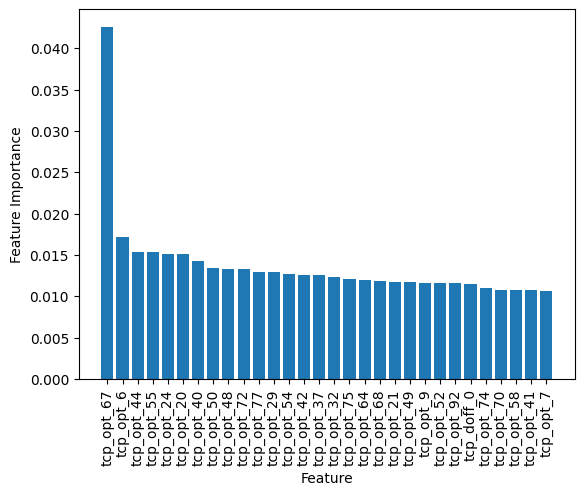

In [9]:
# Import Plotting Libraries
import matplotlib.pyplot as plt
%matplotlib inline

# Get feature importances
importances = clf.feature_importances_

# Sort in descending order
indices = np.argsort(importances)[::-1]

# Sort the labels in a corresponding fashion
labels = nprint_80.columns.values
names = [labels[i] for i in indices]

# Plot
# number of important features to plot
# plt.bar(range(nprint_80.shape[1]),importances[indices])

num = 30
plt.figure()
plt.bar(range(num),importances[indices][:num])
plt.xticks(range(num), names[:num], rotation=90)
plt.ylabel('Feature Importance')
plt.xlabel('Feature')
plt.show()